<a href="https://colab.research.google.com/github/GurjeetSinghSangra/MachineLearningAssignment/blob/main/emnist_DBN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
##################################################
# Imports
##################################################
import numpy as np
import numpy.matlib
import math
import scipy.io
from sklearn import svm, datasets
import time
import matplotlib.pyplot as plt
import torch
import torch.nn as nn #torch made by layers, in nn we have linear layer which implements standard forward fully connected layer
import torch.nn.functional as F 
import torchvision #used for data loading
import torch.optim as optim #optimizer for the gradient
from tqdm.notebook import tqdm
import time


# Setting the device
if torch.cuda.is_available(): 
    print('GPU enabled!')
    device = torch.device("cuda:0")
else:
    print('You are not using the GPU, activate it following:')
    

GPU enabled!


In [30]:
def rotate(image):
    image = image.reshape([28, 28])
    image = np.fliplr(image)
    image = np.rot90(image)
    return image

def autolabel(rects, ax):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.2f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
        
#images = np.apply_along_axis(rotate, 1, x_train)
#plt.imshow(images[1,], cmap=plt.get_cmap('gray')) 

In [45]:
class DBN(nn.Module):

  def __init__(self, layers_nn, maxepochs=50, batchsize=125, epsilonw=0.1, \
                               sparsity=True, spars_factor=0.04, epsilonvb=0.1, epsilonhb=0.1, weightcost=0.0002, init_momentum=0.5, final_momentum=0.9):
    super(DBN, self).__init__()
    self.DN = {}
    self.DN['layersize'] = layers_nn
    self.DN['nlayers'] = len(layers_nn)
    self.DN['batchsize'] = batchsize
    self.DN['maxepochs'] = maxepochs
    self.epsilonw_GPU = epsilonw #learning rate DeltaW = epsilonw (pos_v * pos_h - neg_v * neg_h)
    self.epsilonvb=epsilonvb
    self.epsilonhb=epsilonhb
    self.weightcost = weightcost #constant weight decrease
    self.initialmomentum = init_momentum
    self.finalmomentum = final_momentum
    self.sparsity = sparsity
    self.spars_factor = spars_factor
    self.DN['errors'] = {}
  
  def train_dbn(self, batch, device):

    batchdata = torch.Tensor(batch).to(device)
    nlayers = self.DN['nlayers']
    for layer in range(0, nlayers):
        print ('Training layer ', layer+1, '...')
        if layer == 0:
            data_GPU = batchdata
        else:
            data_GPU = batchposhidprobs
        
        numhid = self.DN['layersize'][layer]
        numcases, numdims, numbatches = data_GPU.shape
        vishid_GPU       = 0.1 * torch.randn(numdims, numhid, device=device) #normal dist weights with standard deviation 0.01
        #print(vishid_GPU.shape)
        hidbiases_GPU    = torch.zeros(numhid, device=device)
        visbiases_GPU    = torch.zeros(numdims, device=device)
        vishidinc_GPU    = torch.zeros((numdims, numhid), device=device)
        hidbiasinc_GPU   = torch.zeros(numhid, device=device)
        visbiasinc_GPU   = torch.zeros(numdims, device=device)
        batchposhidprobs = torch.zeros((numcases, numhid, numbatches), device=device)
        self.DN['errors'][layer] = []


        sigmoid = nn.Sigmoid()
        for epoch in range(self.DN['maxepochs']):
            errsum = 0
            for mb in range(numbatches):
                data_mb = data_GPU[:, :, mb]
                #%%%%%%%% START POSITIVE PHASE %%%%%%%%%
                #1./(1 + exp(-poshidstates * vishid' - repmat(visbiases, numcases, 1))); 
                poshidprobs_GPU = sigmoid((torch.mm(data_mb, vishid_GPU) + hidbiases_GPU))
                posprods_GPU    = torch.mm(data_mb.T, poshidprobs_GPU)
                poshidact_GPU   = poshidprobs_GPU.sum(0)
                #posvisact_GPU   = data_GPU[:, :, mb].sum(0)
                posvisact_GPU   = data_mb.sum(0)
                #%%%%%%%% END OF POSITIVE PHASE %%%%%%%%%
                poshidstates_GPU = poshidprobs_GPU > (torch.rand(numcases, numhid, device=device))
                poshidstates_GPU = torch.gt(poshidstates_GPU, 0).float()

                #%%%%%%%% START NEGATIVE PHASE  %%%%%%%%%
                negdata_GPU     = sigmoid((torch.mm(poshidstates_GPU, vishid_GPU.T) + visbiases_GPU))
                neghidprobs_GPU = sigmoid((torch.mm(negdata_GPU, vishid_GPU) + hidbiases_GPU))
                negprods_GPU    = torch.mm(negdata_GPU.T, neghidprobs_GPU)
                neghidact_GPU   = neghidprobs_GPU.sum(0)
                negvisact_GPU   = negdata_GPU.sum(0)
                #%%%%%%%% END OF NEGATIVE PHASE %%%%%%%%%
                
                err = torch.sqrt(torch.sum(torch.sum((data_mb - negdata_GPU)**2, dim=0)))
                if self.DN['maxepochs']  > 5:
                  self.momentum = self.finalmomentum
                else:
                  self.momentum = self.initialmomentum

                #%%%%%%%% UPDATE WEIGHTS AND BIASES %%%%%%%%%
                vishidinc_GPU  = vishidinc_GPU  * self.momentum + self.epsilonw_GPU * ((posprods_GPU - negprods_GPU) / numcases - self.weightcost * vishid_GPU)
                visbiasinc_GPU = visbiasinc_GPU * self.momentum + (posvisact_GPU - negvisact_GPU) * (self.epsilonvb / numcases)
                hidbiasinc_GPU = hidbiasinc_GPU * self.momentum + (poshidact_GPU - neghidact_GPU) * (self.epsilonhb / numcases)
                vishid_GPU     = vishid_GPU + vishidinc_GPU
                visbiases_GPU  = visbiases_GPU + visbiasinc_GPU
                hidbiases_GPU  = hidbiases_GPU + hidbiasinc_GPU
                #%%%%%%%% END OF UPDATES %%%%%%%%%
                # END RBM
                
                errsum = err + errsum

                if epoch == self.DN['maxepochs']-1:
                    batchposhidprobs[:, :, mb] = poshidprobs_GPU

                #TODO: Sparsity
                if self.sparsity and (layer == nlayers-1):
                  #poshidact_GPU = poshidprobs_GPU.sum(0)
                  Q = poshidact_GPU / self.DN['batchsize']
                  if (torch.mean(Q) > self.spars_factor):
                    hidbiases_GPU = hidbiases_GPU - self.epsilonhb * (Q - self.spars_factor)
              
            #END Batches
            self.DN['errors'][layer].append((epoch, errsum.cpu().clone().numpy()))
          #END Epoches

        # save learned weights
        self.DN['vis_bias' + str(layer)] = visbiases_GPU.cpu().clone().numpy()
        self.DN['hid_bias' + str(layer)] = hidbiases_GPU.cpu().clone().numpy()
        self.DN['vishid'   + str(layer)] = vishid_GPU.cpu().clone().numpy()
        #print(self.DN['vishid'   + str(layer)].shape)

  def simple_load_emnist(fname): 
    dataset = scipy.io.loadmat(fname)
    data_train = dataset['dataset']['train']
    data_test = dataset['dataset']['test']
    x_train = data_train[0,0]['images'][0,0]
    x_train = x_train.astype('float32') / 255
    y_train = data_train[0,0]['labels'][0,0]
    y_train = y_train.astype(int)
    x_test = data_test[0,0]['images'][0,0]
    x_test = x_test.astype('float32')  / 255
    y_test = data_test[0,0]['labels'][0,0]
    y_test = y_test.astype(int)
    return (x_train, y_train, x_test, y_test)

  def load_data(fname, NUMB_CLASSES, batchsize):
    dataset = scipy.io.loadmat(fname)
    data_train = dataset['dataset']['train']
    data_test = dataset['dataset']['test']
    x_train = data_train[0,0]['images'][0,0]
    x_train = x_train.astype('float32') / 255
    y_train = data_train[0,0]['labels'][0,0]
    y_train = y_train.astype(int)
    x_test = data_test[0,0]['images'][0,0]
    x_test = x_test.astype('float32')  / 255
    y_test = data_test[0,0]['labels'][0,0]
    y_test = y_test.astype(int)

    iterations = int(len(x_train)/batchsize)
    batchdata = np.zeros(shape=(batchsize, 784, iterations), dtype='float32')

    for i in range(batchsize):
      for j in range(iterations):
        batchdata[i, :,j] = x_train[i*j, :]

    length_train = int(len(x_train))
    tr_labels = np.zeros(shape=(length_train, NUMB_CLASSES))
    for i in range(length_train):
        tr_labels[i, y_train[i]] = 1.0

    length_test = int(len(y_test))
    te_labels = np.zeros(shape=(length_test, NUMB_CLASSES))
    for i in range(length_test):
        te_labels[i, y_test[i]] = 1.0

    return (x_train, tr_labels, x_test, te_labels, batchdata)


  def to_string(self):
      if self.sparsity:
        sparsity_text = ' Sparse'
      else:
        sparsity_text = ''
      return "DBN: {0}, {1}, {2} {3}".format(str(self.DN['layersize']), \
                                             self.DN['batchsize'], \
                                             self.DN['maxepochs'], sparsity_text)

  

In [32]:
class HyperParameterConf:

  def __init__(self, layers_nn, maxepochs=50, batchsize=125, epsilonw=0.1, \
               sparsity=True, spars_factor=0.04, epsilonvb=0.1, epsilonhb=0.1, \
               weightcost=0.0002, init_momentum=0.5, final_momentum=0.9):
    
    self.layers = layers_nn
    self.batchsize= batchsize
    self.maxepochs = maxepochs
    self.epsilonw = epsilonw #learning rate DeltaW = epsilonw (pos_v * pos_h - neg_v * neg_h)
    self.epsilonvb=epsilonvb
    self.epsilonhb=epsilonhb
    self.weightcost = weightcost #constant weight decrease
    self.init_momentum = init_momentum
    self.final_momentum = final_momentum
    self.sparsity = sparsity
    self.spars_factor = spars_factor
  
  def get_dbn_model(self):
    return DBN(layers_nn=self.layers, maxepochs=self.maxepochs, \
               batchsize=self.batchsize, epsilonw=self.epsilonw, \
               sparsity=self.sparsity, spars_factor=self.spars_factor, \
               epsilonvb=self.epsilonvb, epsilonhb=self.epsilonhb, \
               weightcost=self.weightcost, init_momentum=self.init_momentum, \
               final_momentum=self.final_momentum)
    
  def to_string(self):
      if self.sparsity:
        sparsity_text = ' Sparse'
      else:
        sparsity_text = ''
      return "DBN: {0}, {1}, {2} {3}".format(str(self.layers), \
                                             self.batchsize, \
                                             self.maxepochs, sparsity_text)
  

In [33]:
from scipy.linalg import lstsq
def perceptron_CPU(tr_patterns, tr_labels, te_patterns, te_labels):

  te_accuracy = 0;
  tr_accuracy = 0;

  # add biases
  tr_patterns_CPU = np.hstack((tr_patterns, np.ones((len(tr_patterns), 1))))
  weights, res, rnk, s= lstsq(tr_patterns_CPU, tr_labels)
  # training accuracy
  pred = np.dot(tr_patterns_CPU, weights)
  max_act_idx = np.argmax(pred, axis=1)
  r = np.nonzero(tr_labels)[1]
  acc = max_act_idx == r

  tr_accuracy = np.mean(acc)

  # test accuracy
  te_patterns_CPU = np.hstack((te_patterns, np.ones((len(te_patterns), 1))))
  pred = np.dot(te_patterns_CPU, weights)
  max_act_idx = np.argmax(pred, axis=1)
  r = np.nonzero(te_labels)[1]
  acc = (max_act_idx == r)
  te_accuracy = np.mean(acc)
  return {"tr_accuracy": tr_accuracy, "te_accuracy": te_accuracy}

In [46]:
#MNIST Train 60000 ---> 125 --> 480
#Letters Train 124800 ---> 260 or 240
#Digits Train 240000 --->
#Balanced Train 112800 -->


x1 = time.strftime('%s')
namedataset = 'letters'
fname = ('/home/emnist-' + namedataset + '.mat')

batch_dict = {"mnist" : 125,
              "letters" : 240,
              "digits" : 200,
              "balanced" :  200}
NUMB_CLASSES = {"mnist" : int(10),
              "letters" : int(37),
              "digits" : int(10),
              "balanced" :  int(47)}

x2 = time.strftime('%s')
timediff = int(x2) - int(x1)

####### HYPER PARAMTERS of DBN ####################
# layers_nn, maxepochs=50, batchsize=125, epsilonw=0.1,
# sparsity=True, spars_factor=0.04, epsilonvb=0.1, epsilonhb=0.1, 
# weightcost=0.0002, init_momentum=0.5, final_momentum=0.9):

dbn_models_conf = []
dbn_models_conf.append(HyperParameterConf(layers_nn = np.array([784, 500]), \
                           epsilonw=0.03, batchsize=batch_dict[namedataset], \
                           maxepochs=50, sparsity=False))

#dbn_models_conf.append(HyperParameterConf(layers_nn = np.array([784, 500, 2000]), \
#                          epsilonw=0.05, batchsize=batch_dict[namedataset], \
#                           maxepochs=150, sparsity=False))

#dbn_models_conf.append(HyperParameterConf(layers_nn = np.array([784, 500, 2000]), \
#                           epsilonw=0.03, batchsize=batch_dict[namedataset], \
#                           maxepochs=200, sparsity=False))

#dbn_models_conf.append(HyperParameterConf(layers_nn = np.array([784, 500, 500, 2000]), \
#                           epsilonw=0.03, batchsize=batch_dict[namedataset], \
#                           maxepochs=200, sparsity=False))

Raw Data perceptron Accuracy: 59.30, test accuracy: 57.79
DBN model 1 DBN: [784 500], 240, 50 
Training begin
Training layer  1 ...
Training layer  2 ...
Training done
Read out Level 1 DBN layer accuracy: 80.12, test accuracy: 79.37
Read out Level 2 DBN layer accuracy: 74.89, test accuracy: 74.30
1
[59.3  80.12 74.89]
[59.3  80.12 74.89]


TypeError: ignored

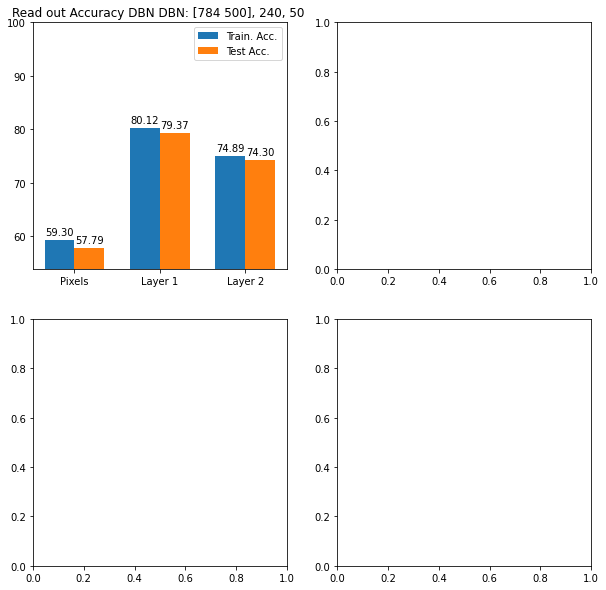

In [47]:
results = []
x_train, y_train, x_test, y_test, batch_data = DBN.load_data(fname, NUMB_CLASSES[namedataset], batch_dict[namedataset])
del batch_data
results.append(perceptron_CPU(x_train, y_train, x_test, y_test))
print('Raw Data perceptron Accuracy: {0:.2f}, test accuracy: {1:.2f}'.format(results[0]['tr_accuracy'] * 100, results[0]['te_accuracy'] * 100))


n_models = len(dbn_models_conf)
fig, axes = plt.subplots(n_models+1, 2, figsize=(10, 10))
i = 1
j = 1
res_idx = i
width=0.35
for dbn_model_conf in dbn_models_conf:
  dbn_model = dbn_model_conf.get_dbn_model()
  x_train, y_train, x_test, y_test, batch_data = DBN.load_data(fname, NUMB_CLASSES[namedataset], dbn_model.DN['batchsize'])
  print("DBN model {0} {1}".format(i, dbn_model.to_string()))
  print('Training begin')
  dbn_model.train_dbn(batch_data, device=device)
  print("Training done")
  
  axis = axes[i-1, 0]
  
  prev_train = x_train
  prev_test = x_test
  nlayers = dbn_model.DN['nlayers']
  for layer_idx in range(nlayers):
    vishid = dbn_model.DN['vishid' + str(layer_idx)]
    hid_bias = dbn_model.DN['hid_bias' + str(layer_idx)]
    H_tr = 1 /(1 + np.exp(-np.dot(prev_train, vishid) - np.matlib.repmat(hid_bias, len(prev_train), 1)));
    H_te = 1 /(1 + np.exp(-np.dot(prev_test, vishid) - np.matlib.repmat(hid_bias, len(prev_test), 1)));
    results.append(perceptron_CPU(H_tr, y_train, H_te, y_test))
    tr_accuracy  = results[j]['tr_accuracy']
    te_accuracy = results[j]['te_accuracy'] 
    print('Read out Level {0} DBN layer accuracy: {1:.2f}, test accuracy: {2:.2f}'.format(layer_idx+1, tr_accuracy  * 100, te_accuracy  * 100))
    prev_train = H_tr
    prev_test = H_te
    j += 1

  #PLOT Accuracies
  plot_accuracies(dbn_model.to_string(), results, axis, nlayers, prev_nlayers, res_idx, j)

  #### PLOT Errors
  #axis = axes[i-1, 1]
  #plot_errors(dbn_model, axis)

  prev_nlayers = nlayers
  i = i +1
  res_idx += 1

for ax in axes[n_models, :]
  fig.delaxes(ax)
plt.show()

In [22]:
def plot_accuracies (dbn_title, results, axis, nlayers,prev_nlayers, res_idx, j):
  width=0.35
  tr_accuracies = [results[0]['tr_accuracy']]
  te_accuracies = [results[0]['te_accuracy']]
  
  if res_idx > 1:
    res_idx = res_idx + prev_nlayers -1
  print(res_idx)
  #concatate first results with others
  tr_accuracies = tr_accuracies + list(map(lambda val: val['tr_accuracy'], results[res_idx:j]))
  te_accuracies = te_accuracies + list(map(lambda val: val['te_accuracy'], results[res_idx:j]))
  tr_accuracies = np.array(tr_accuracies) * 100
  te_accuracies = np.array(te_accuracies) * 100

  x = np.arange(nlayers+1) 
  print(tr_accuracies)
  print(tr_accuracies)
  bar_tr = axis.bar(x - width/2, tr_accuracies, width, label='Train. Acc.')
  bar_te = axis.bar(x + width/2, te_accuracies, width, label='Test Acc.')
  axis.set_xticks(x)
  x_labels = list(map(lambda value : 'Layer {0}'.format(value), np.arange(nlayers+1)))
  x_labels[0] = 'Pixels'
  axis.set_xticklabels(x_labels)
  axis.legend()
  axis.set_label("Percentage")
  axis.set_title("Read out Accuracy DBN {0}".format(dbn_title))
  minimum = min(tr_accuracies.min(), te_accuracies.min())
  if minimum > 5:
    minimum -= 4
  axis.set_ylim(minimum, 100)
  autolabel(bar_tr, axis)
  autolabel(bar_te, axis)

In [20]:
def plot_errors(dbn_model, axis):
  nlayers = dbn_model.DN['nlayers']
  legends = []
  legend_name = []
  for layer in range(nlayers):
    values = dbn_model.DN['errors'][layer]
    x, y = zip(*values)
    leg,  = axis.plot(x, y)
    legends.append(leg)
    legend_name.append('L{0}'.format(layer+1))

  axis.legend(legends, legend_name, loc='upper right', shadow=True)
  title = 'Errors DBN model {0}'.format(dbn_model.to_string)
  axis.set_title(title)

In [ ]:
i = 1
for dbn_model in dbn_models:
  savematname = 'DN_COLAB_{0}.mat'.format(i, dbn_model.to_string())
  scipy.io.savemat(savematname, {'DN': dbn_model.DN})
  print(savematname)
  i = i + 1

DN_COLAB_1_mnist.mat


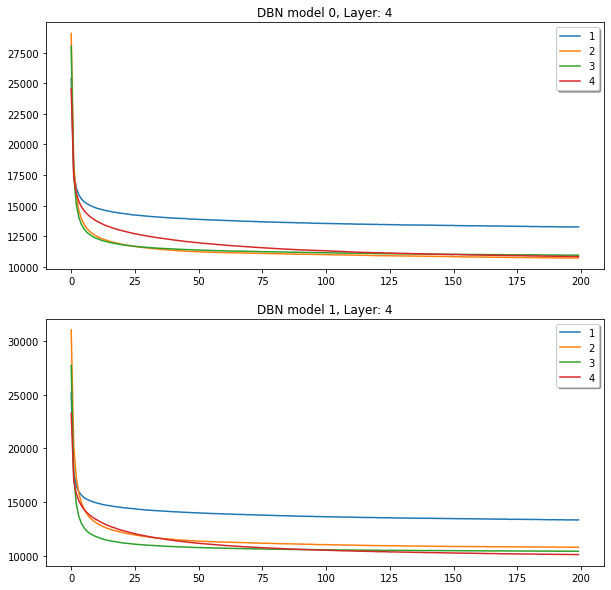

In [ ]:
def get_cmap(n, name='hsv'):
    return plt.cm.get_cmap(name, n)

i=0
n_models = len(dbn_models)
fig, axes = plt.subplots(n_models, figsize=(10,10))

for dbn_model in dbn_models:
  nlayers = dbn_model.DN['nlayers']
  legends = []
  legend_name = []
  if n_models > 1:
      axis = axes[i]
  else:
      axis = axes
  for layer in range(nlayers):
    values = dbn_model.DN['errors'][layer]
    x, y = zip(*values)
    title = 'DBN model {0}, Layer: {1}'.format(i, layer+1)
    
    leg,  = axis.plot(x, y)
    legends.append(leg)
    legend_name.append(str(layer+1))

  axis.legend(legends, legend_name, loc='upper right', shadow=True)
  axis.set_title(title)
  i+=1

plt.show()


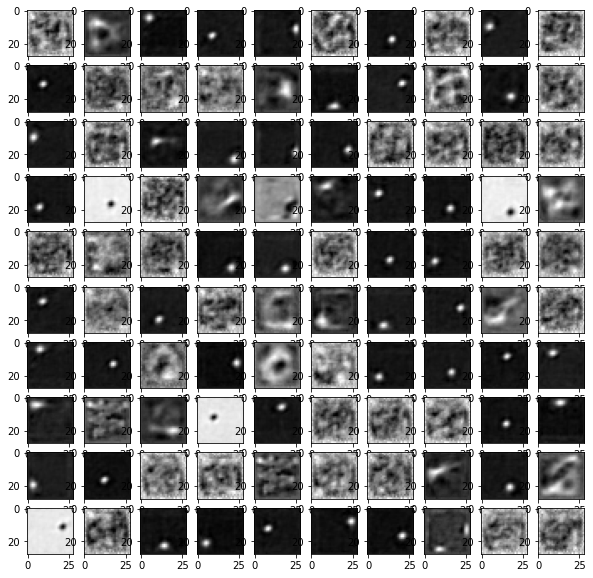

In [95]:
fig, axes = plt.subplots(n_models+1, 2, figsize=(10, 10))
plot_layer(dbn_model.DN, 100)

In [94]:
import cv2 as cv
def plot_layer(DN, n_hidden):
  #self.DN['vis_bias' layer]
  #self.DN['hid_bias' layer]
  v, h = DN['vishid1'].shape # number of visible and hidden units
  imgsize = int(math.sqrt(v));
  if n_hidden > h:
      n_hidden = h;

  n_x = math.floor(math.sqrt(n_hidden))
  n_y = n_x
  n_hidden = n_x * n_y;

  row = 0
  column = 0
  fig, axes = plt.subplots(n_x, n_x, figsize=(10, 10))
  for i_n in range(n_hidden):
    # Select (strong) inputs to L3(i_n)
    W2 = DN['vishid1'][:, i_n]
    #W3 = W3.detach().cpu().clone().numpy()
    W2 = np.multiply(W2, (np.abs(W2) > 0.0))
    # Select (strong) inputs to L2
    W1 = DN['vishid0']
    #W2 = W2.detach().cpu().clone().numpy()
    W1 = np.multiply(W1, (np.abs(12) > 0.0))
    
    # Weight filters with a linear combination
    ww = np.dot(W1, W2)
    ww = np.multiply(ww, np.abs(ww) > 0.0) # threshold

    #print(ww.shape)
    #print(ww)
    if column == n_y:
      row += 1
      column = 0

    axis = axes[row, column]
    #sub = fig.add_subplot(n_y, n_x, i_n+1)
    axis.imshow(ww.reshape((imgsize, imgsize)), cmap=plt.cm.gray)
    column +=1

  plt.show()

In [ ]:
plot_layer(dbn_model.DN, 100)

In [7]:
class LeastSquares:
    def __init__(self):
        pass
    
    def lstq(self, A, Y, lamb=0.0):
        """
        Differentiable least square
        :param A: m x n
        :param Y: n x 1
        """
        # Assuming A to be full column rank
        cols = A.shape[1]
        print (torch.matrix_rank(A))
        if cols == torch.matrix_rank(A):
            q, r = torch.qr(A)
            x = torch.inverse(r) @ q.T @ Y
        else:
            A_dash = A.permute(1, 0) @ A + lamb * torch.eye(cols)
            Y_dash = A.permute(1, 0) @ Y
            x = self.lstq(A_dash, Y_dash)
        return x


In [8]:
def perceptron_GPU(tr_patterns, tr_labels, te_patterns, te_labels, device):

  #biases
  tr_patterns_GPU = torch.Tensor(np.hstack((tr_patterns, np.ones((len(tr_patterns), 1)))), dtype=torch.float).to(device)
  tr_labels_GPU = torch.Tensor(tr_labels, dtype=torch.float).to(device)
  print(tr_patterns_GPU.shape)
  print(tr_labels_GPU.shape)
  #weights, _ = torch.lstsq(tr_labels_GPU, tr_patterns_GPU)
  #data_rows, x_columns = tr_patterns_GPU.shape
  ls = LeastSquares()
  weights = ls.lstq(tr_patterns_GPU, tr_labels_GPU, 0.010)
  #weights = weights[:x_columns, :]
  #print(torch.pinverse(tr_patterns_GPU).shape)
  #weights = (tr_labels'*pinv(tr_patterns'))';
  print(weights.shape)
  print(weights[0, :])

  pred = torch.mm(tr_patterns_GPU, weights)
  print(pred.shape)
  print(pred[0:10, :])
  max_act_idx = torch.argmax(pred, dim=1)
  r = torch.argmax(tr_labels_GPU, dim=1)
  acc = (max_act_idx == r)
  acc = acc.long()
  tr_accuracy = torch.mean(acc)

  # test accuracy
  te_patterns_GPU = torch.Tensor(te_patterns).to(device)
  data_rows, _ = te_patterns_GPU.shape
  te_patterns_GPU = torch.hstack(torch.ones(data_rows, 1))
  te_labels_GPU = torch.Tesor(te_labels).to(device)
  pred = torch.mm(te_patterns_GPU, weights)
  max_act_idx = torch.argmax(pred, dim=1)
  r = torch.argmax(te_labels_GPU, dim=1)
  acc = (max_act_idx == r)
  acc = acc.long()
  te_accuracy = torch.mean(acc)
  return {"tr_accuracy": tr_accuracy.detach().cpu().numpy(), "te_accuracy": te_accuracy.detach().cpu().numpy()}

In [ ]:
x_train, y_train, x_test, y_test, batchdata = DBN.load_data(fname, NUMB_CLASSES[namedataset], dbn_model.DN['batchsize'])
del batchdata
tr_accuracy, te_accuracy = perceptron_GPU(x_train, y_train, x_test, y_test, device)